In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
df = pd.read_csv('Preprocess_Reviews.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,neg,neu,pos,compound
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel lucky found used phone u used hard phone ...,1.0,positive,0.100,0.592,0.308,0.8966
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,positive,0.155,0.445,0.400,0.8548
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,pleased,0.0,positive,0.000,0.000,1.000,0.4404
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,work good go slow sometimes good phone love,0.0,positive,0.000,0.333,0.667,0.8750
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,positive,0.103,0.714,0.183,0.4215


In [39]:
#Drop unnecessary columns:
df = df.drop(['Product Name', 'Price', 'Review Votes', 'Brand Name'], axis=1)
df.dropna(inplace=True)

In [40]:
df_Positive = df[df['sentiment'] == 'positive'][0:20000]
df_Neutral = df[df['sentiment'] == 'neutral']
df_Negative = df[df['sentiment'] == 'negative']

In [41]:
df_Neutral_over = df_Neutral.sample(20000, replace=True)
df_Negative_over = df_Negative.sample(20000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [42]:
df

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215
...,...,...,...,...,...,...,...
118130,1,beautiful bud bad product touch screen working...,negative,0.227,0.519,0.253,0.1027
58543,1,longer recognize sim card blackberry provide s...,negative,0.000,0.608,0.392,0.6997
98509,1,glitch much screen would freeze time let send ...,negative,0.078,0.749,0.173,0.3182
164652,1,send back year go naver got thing back,negative,0.000,1.000,0.000,0.0000


In [43]:
# Tokenization and padding
max_length = 100  # Adjust according to your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Reviews'])
X = tokenizer.texts_to_sequences(df['Reviews'])
X = pad_sequences(X, maxlen=max_length)

In [44]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])


In [45]:
# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)


In [46]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Define model parameters
embedding_dim = 100  # Dimension of word embeddings
vocab_size = len(tokenizer.word_index) + 1


In [48]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))  # Dropout layer to prevent overfitting
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

C:\Users\MK Jutt\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [50]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
epochs = 10
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 566ms/step - accuracy: 0.5698 - loss: 0.8529 - val_accuracy: 0.7667 - val_loss: 0.5590
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 225s 601ms/step - accuracy: 0.8070 - loss: 0.5075 - val_accuracy: 0.8045 - val_loss: 0.5007
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 591ms/step - accuracy: 0.8527 - loss: 0.4092 - val_accuracy: 0.8120 - val_loss: 0.4900
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 224s 597ms/step - accuracy: 0.8770 - loss: 0.3449 - val_accuracy: 0.8267 - val_loss: 0.5006
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 227s 606ms/step - accuracy: 0.8947 - loss: 0.3016 - val_accuracy: 0.8276 - val_loss: 0.5000
Epoch 5: early stopping


In [52]:
# Evaluate model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8213 - loss: 0.5170
Validation Loss: 0.5000
Validation Accuracy: 0.8276


In [53]:

# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

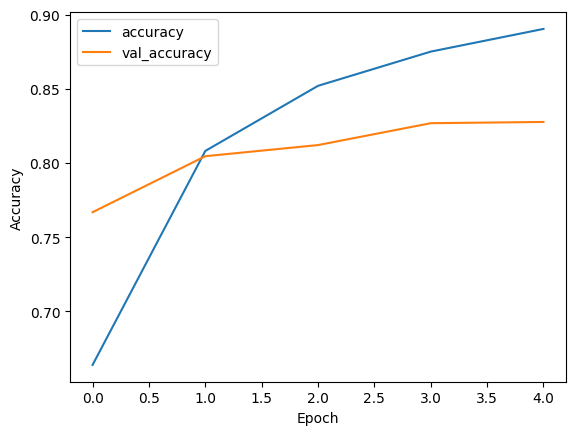

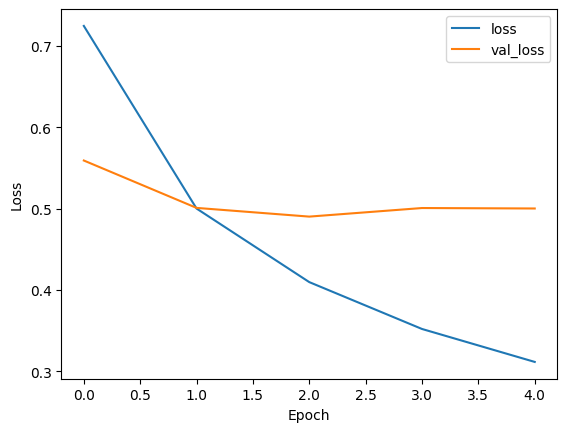

In [54]:
# Plot accuracy and loss
plot_history(history)

In [55]:
# Example of making predictions
new_reviews = ["My phone not working welll", "I appreciate that company to providing good product."]
sequences = tokenizer.texts_to_sequences(new_reviews)
padded_sequences = pad_sequences(sequences, maxlen=max_length)
predictions = model.predict(padded_sequences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


In [56]:
# Decode predictions
predicted_labels = label_encoder.inverse_transform([np.argmax(pred) for pred in predictions])

In [57]:
for review, predicted_label, prediction in zip(new_reviews, predicted_labels, predictions):
    sentiment = predicted_label
    confidence = prediction[np.argmax(prediction)]
    print(f'Review: {review} | Predicted Sentiment: {sentiment} | Confidence: {confidence:.4f}')

Review: My phone not working welll | Predicted Sentiment: negative | Confidence: 0.5858
Review: I appreciate that company to providing good product. | Predicted Sentiment: positive | Confidence: 0.9796
